# Customised advice
In order to create customised advice several steps will be taken. First based on the PV data and the total energy use a model will be made of the day which detects the so called opportunity hours. Opportunity hours are times where there is more energy generated than used. The second step will be to detect if a reschedulable appliance is being used outside of opportunity hours. Then with that info the custom advice is generated to let the user know how their behaviour could change to be more sustainable.

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
from nilmtk import DataSet, TimeFrame, MeterGroup, HDFDataStore
from enum import Enum
from random import randint
from datetime import time
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

dred = DataSet('data/DRED.h5')

%matplotlib inline

dred.set_window(start="10-18-2015", end="10-19-2015")

data = dred.buildings[1].elec

## Plot PV generation and total energy use
The two lists below contain test data of PV generation and total energy use. By plotting the two lists over each other it becomes visible how a lot of the energy is used in periods where there is little or no energy generation.

In [3]:
pv_test_data = [0.0, 0.0, 0.0, 0.0, 0.0, 12.713, 214.371, 737.432, 1410.714, 2039.156, 2452.865, 2729.085, 2792.666, 2673.155, 2365.469, 1821.737, 1121.648, 454.233, 104.846, 0.0, 0.0, 0.0, 0.0, 0.0]

energy_test_data = data.mains().load().next()
energy_test_data = energy_test_data.resample('H').mean()
energy_test_data = energy_test_data.power.apparent.tolist()

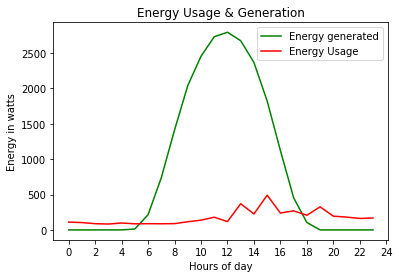

In [4]:
plt.plot(pv_test_data, 'g', label="Energy generated")
plt.plot(energy_test_data, 'r', label="Energy Usage")

yaxis_height= 3000
yaxis_depth = 0
tx = np.arange(0, 24, 0.2)
plt.ylabel('Energy in watts')
plt.legend(loc='upper right')
plt.xlabel("Hours of day")
plt.title('Energy Usage & Generation')
plt.xticks(np.arange(min(tx), max(tx) + 1, 2))

plt.show()

## Subtracting lists
Below it the two lists are subtracted from each other. By doing this it becomes visible at what times there is a possitive energy output and when there is a negative energy output. Positive meaning more energy being generated than used and negative meaning the opposite.

In [5]:
opportunities = []
for pv, used in zip(pv_test_data, energy_test_data):
    watts = pv - used
    opportunities.append(watts)

## Plot opportunity
To visualize the opportunity times in one day the following graph is plotted. When the blue line is above the dashed line there is an opportunity because more energy is generated than used.

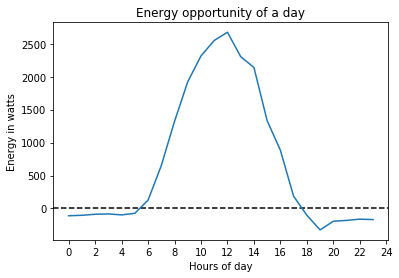

In [6]:
plt.axhline(color='black', linestyle='--')
plt.plot(opportunities)
tx = np.arange(0, 24, 0.2)
plt.ylabel('Energy in watts')
plt.xlabel("Hours of day")
plt.title('Energy opportunity of a day')
plt.xticks(np.arange(min(tx), max(tx) + 1, 2))

plt.show()

## List of opportunity times
In order to schedule better times for appliance use we'll make a list with desired appliance time ranges. The list will be two dimensional. Each item will contain a start and an end time.

In [7]:
opportunity_found = False
opportunity_times = []
start_time = -1
end_time = -1
for opportunity in opportunities:   
    if opportunity > 0.0 and opportunity_found == False:
        start_time = time(opportunities.index(opportunity))
        opportunity_found = True
    elif opportunity <= 0.0 and opportunity_found == True:
        end_time = time(opportunities.index(opportunity) - 1)
        opportunity_times.append([start_time, end_time])
        opportunity_found = False
        
print(opportunity_times)

[[datetime.time(6, 0), datetime.time(17, 0)]]


# Check if  washing machineappliance is used outside of opportunity times
To reschedule first the application has to know if the appliance is used within the opportunity times. We are going to use the washing machine as an example. The graph below depicts the use of the washing machine on one day.

/home/nbuser/anaconda2_501/lib/python2.7/site-packages/nilmtk/utils.py:390: FutureWarning: fill_method is deprecated to .resample()
the new syntax is .resample(...).ffill(limit=1)
  data = data.resample(**resample_kwargs)


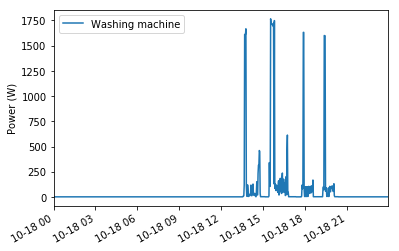

In [8]:
washing_machine = data['washing machine']
washing_machine.plot()

## Filter and downsample
This data has a sampling size of one second. We only have to detect if the appliance is on. For that reason we first remove all the values that are close to zero because these values indicate that the appliance is idle. Then we downsample the values too one hour. We do this by taking the average of each hour. This changes the unit to watt per hour.

,power
,apparent
2015-10-18 00:00:00+02:00,0.000000
2015-10-18 01:00:00+02:00,0.000000
2015-10-18 02:00:00+02:00,0.000000
2015-10-18 03:00:00+02:00,0.000000
2015-10-18 04:00:00+02:00,0.000000
2015-10-18 05:00:00+02:00,0.000000
2015-10-18 06:00:00+02:00,0.000000
2015-10-18 07:00:00+02:00,0.000000
2015-10-18 08:00:00+02:00,0.000000


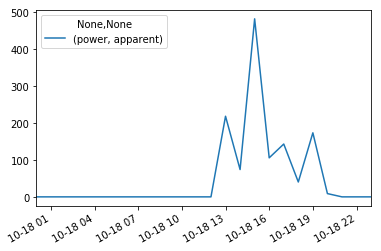

In [9]:
washing_resampled = washing_machine.load().next()
washing_resampled = washing_resampled.replace(0.95, 0.0)
washing_resampled = washing_resampled.resample('H').mean()

washing_resampled.plot()

washing_resampled

## Plot opportunity vs washing machine graph
The next step is to detect if the appliance is being used outside of opportunity times. First a graph is plotted to visualize the times where the energy is used outside of opportunity times.

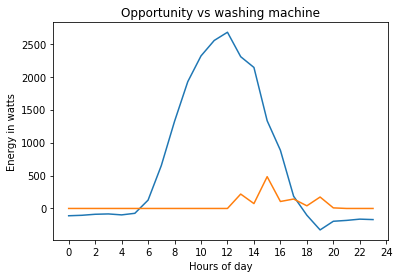

In [10]:
washing_list = washing_resampled.power.apparent.tolist()
plt.plot(opportunities, label="Opportunity")
plt.plot(washing_list, label="Washing machine energy use")
tx = np.arange(0, 24, 0.2)
plt.ylabel('Energy in watts')
plt.xlabel("Hours of day")
plt.title('Opportunity vs washing machine')
plt.xticks(np.arange(min(tx), max(tx) + 1, 2))

plt.show()

## Compare active time to opportunity time
As shown in the graph above the washingmachine is indeed used outside of opportunity times. To have the code detect this automatically we use the following code.

In [11]:
notification_data = []

for washing_hour_value in washing_list:
    if washing_hour_value > 0:
        washing_hour = time(washing_list.index(washing_hour_value))
        
        for opportunity_time in opportunity_times:
            if washing_hour < opportunity_time[0] or washing_hour > opportunity_time[1]:
                print "Appliance used outside of opportunity hours found: %s" % washing_hour
                notification_data.append(["Washing machine", washing_hour])
                
notification_data

Appliance used outside of opportunity hours found: 18:00:00
Appliance used outside of opportunity hours found: 19:00:00
Appliance used outside of opportunity hours found: 20:00:00


[['Washing machine', datetime.time(18, 0)],
 ['Washing machine', datetime.time(19, 0)],
 ['Washing machine', datetime.time(20, 0)]]

# Construct notification
So with the data available on which appliance was used at what time outside of the opportunity hours a notification can be constructed. This could be done by using the same notification style each time.

In [12]:
for notification in notification_data:
    print "The %s was on at %s at this time energy generation was low." % (notification[0], notification[1])

The Washing machine was on at 18:00:00 at this time energy generation was low.
The Washing machine was on at 19:00:00 at this time energy generation was low.
The Washing machine was on at 20:00:00 at this time energy generation was low.


## Diverse notifications
It is also possible to construct notifications from a set of possible templates

In [13]:
for notification in notification_data:
    random_notification_number = randint(0, 2)

    if random_notification_number == 0:
        print "The %s was on at %s, try using it during sun hours!" % (notification[0], notification[1])
    elif random_notification_number == 1:
        print "75 percent of neighbours us their %s between %s and %s to save energy." % (notification[0], opportunity_times[0][0], opportunity_times[0][1])
    elif random_notification_number == 2:
        print "Turning on the %s at %s next time will make put your household in the top 3 most sustainable homes." % (notification[0], opportunity_times[0][0])

The Washing machine was on at 18:00:00, try using it during sun hours!
75 percent of neighbours us their Washing machine between 06:00:00 and 17:00:00 to save energy.
75 percent of neighbours us their Washing machine between 06:00:00 and 17:00:00 to save energy.


# Appliance priority
The process displayed above can be used to generate notifications for every appliance you want. To automate this process you need to take each appliance into consideration. Different appliances have different priorities. The ability to reschedule an appliance while taking comfort into considerations is what decides which priority a device has. We can devide appliances into four different catagories.


| Name | Level| Definition                                                                | Example          |
|:---------|:---|:------------------------------------------------------------------------|:-----------------|
| NotReschedulable| 1| Appliance can not be rescheduled                                        | Fridge      | 
| RestrictedReschedulable | 2| Appliance can be rescheduled but appliance probably has to be used now | Oven |
| UncomfortableReschedulable| 3| Appliance can be rescheduled but comfort will suffer| TV                    | 
| Reschedulable| 4| Appliance can be rescheduled| Washing machine                                            |

To keep track of priority the following enumeration can be used:

In [14]:
class Priority(Enum):
    NotReschedulable= 1
    RestrictedReschedulable = 2
    UncomfortableReschedulable = 3
    Reschedulable = 4

## Adding priority to appliance
Now the priority has been defined this can be added to the appliances. In practise this can be done using a class. This however is not practical when using Jupyter. As an alternative we will use a dictionary which contains the appliance names and the priority. This way we can look up the priority for the appliances in the dataset.

In [15]:
appliances_with_priorities = {
    "site meter" : Priority.NotReschedulable,
    "television" : Priority.UncomfortableReschedulable,
    "fan" : Priority.RestrictedReschedulable,
    "fridge" : Priority.NotReschedulable,
    "laptop computer" : Priority.UncomfortableReschedulable,
    "electric heating element" : Priority.RestrictedReschedulable,
    "oven" : Priority.RestrictedReschedulable,
    "unknown" : Priority.Reschedulable,
    "washing machine" : Priority.Reschedulable,
    "microwave" : Priority.RestrictedReschedulable,
    "toaster" : Priority.RestrictedReschedulable,
    "sockets" : Priority.UncomfortableReschedulable,
    "cooker" : Priority.RestrictedReschedulable,
}

appliances_with_priorities

{'cooker': <Priority.RestrictedReschedulable: 2>,
 'electric heating element': <Priority.RestrictedReschedulable: 2>,
 'fan': <Priority.RestrictedReschedulable: 2>,
 'fridge': <Priority.NotReschedulable: 1>,
 'laptop computer': <Priority.UncomfortableReschedulable: 3>,
 'microwave': <Priority.RestrictedReschedulable: 2>,
 'oven': <Priority.RestrictedReschedulable: 2>,
 'site meter': <Priority.NotReschedulable: 1>,
 'sockets': <Priority.UncomfortableReschedulable: 3>,
 'television': <Priority.UncomfortableReschedulable: 3>,
 'toaster': <Priority.RestrictedReschedulable: 2>,
 'unknown': <Priority.Reschedulable: 4>,
 'washing machine': <Priority.Reschedulable: 4>}

# Select most consuming appliances
In the example above one appliance was selected hardcoded. It would be more useful to look at the most consuming appliances, to check if they have a priority which allows rescheduling and then to generate notifications.

In [16]:
top_five_appliances = data.select_top_k(k=5).meters

reschedulable_appliances = []

for appliance in top_five_appliances:
    if appliances_with_priorities[appliance.label().lower()].value != Priority.NotReschedulable.value:
        if appliance.label() !=  "Site meter":
            reschedulable_appliances.append(appliance)

13/13 ElecMeter(instance=13, building=1, dataset='DRED', appliances=[Appliance(type='cooker', instance=1)]))])1)])ance=1)])

/home/nbuser/anaconda2_501/lib/python2.7/site-packages/nilmtk/metergroup.py:1301: FutureWarning: sort is deprecated, use sort_values(inplace=True) for INPLACE sorting
  top_k_series.sort(ascending=asc)


## Looking through all appliances
The following code can be used to construct an array which contains all the hours at which one of the reschedulable appliances is used outside of opportunity hours.

In [17]:
raw_appliance_data = []
appliances_notification_data = []

for appliance in reschedulable_appliances:
    raw_appliance = appliance.load().next()
    raw_appliance = raw_appliance.resample('H').mean()
    raw_appliance = raw_appliance.power.apparent.tolist()
    raw_appliance_data.append([appliance.label(), raw_appliance])
    
for appliance in raw_appliance_data:
    for hour_value in appliance[1]:
        if hour_value > 1:
            hour = time(appliance[1].index(hour_value))
            
            for opportunity_time in opportunity_times:
                if hour < opportunity_time[0] or hour > opportunity_time[1]:
                    print "%s was used outside of opportunity hours at: %s" %(appliance[0], hour)
                    appliances_notification_data.append([appliance[0], hour])


Laptop computer was used outside of opportunity hours at: 18:00:00
Laptop computer was used outside of opportunity hours at: 19:00:00
Laptop computer was used outside of opportunity hours at: 20:00:00
Laptop computer was used outside of opportunity hours at: 21:00:00
Laptop computer was used outside of opportunity hours at: 22:00:00
Laptop computer was used outside of opportunity hours at: 23:00:00
Electric heating element was used outside of opportunity hours at: 00:00:00
Electric heating element was used outside of opportunity hours at: 01:00:00
Electric heating element was used outside of opportunity hours at: 02:00:00
Electric heating element was used outside of opportunity hours at: 03:00:00
Electric heating element was used outside of opportunity hours at: 04:00:00
Electric heating element was used outside of opportunity hours at: 05:00:00
Electric heating element was used outside of opportunity hours at: 18:00:00
Electric heating element was used outside of opportunity hours at:

In [18]:
for notification in appliances_notification_data:
    random_notification_number = randint(0, 2)

    if random_notification_number == 0:
        print "The %s was on at %s, try using it during sun hours!" % (notification[0], notification[1])
    elif random_notification_number == 1:
        print "75 percent of neighbours us their %s between %s and %s to save energy." % (notification[0], opportunity_times[0][0], opportunity_times[0][1])
    elif random_notification_number == 2:
        print "Turning on the %s at %s next time will make put your household in the top 3 most sustainable homes." % (notification[0], opportunity_times[0][0])

75 percent of neighbours us their Laptop computer between 06:00:00 and 17:00:00 to save energy.
75 percent of neighbours us their Laptop computer between 06:00:00 and 17:00:00 to save energy.
The Laptop computer was on at 20:00:00, try using it during sun hours!
Turning on the Laptop computer at 06:00:00 next time will make put your household in the top 3 most sustainable homes.
The Laptop computer was on at 22:00:00, try using it during sun hours!
Turning on the Laptop computer at 06:00:00 next time will make put your household in the top 3 most sustainable homes.
Turning on the Electric heating element at 06:00:00 next time will make put your household in the top 3 most sustainable homes.
75 percent of neighbours us their Electric heating element between 06:00:00 and 17:00:00 to save energy.
The Electric heating element was on at 02:00:00, try using it during sun hours!
The Electric heating element was on at 03:00:00, try using it during sun hours!
The Electric heating element was on